In [96]:
use_gpu = False

In [97]:
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm

import os
import sys
sys.path.insert(0, '..')

if use_gpu:
    from utils.gpu_tools import *
    os.environ["CUDA_VISIBLE_DEVICES"] = ','.join([ str(obj) for obj in select_gpu(query_gpu())])

os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

torch.manual_seed(42)

IMAGE_WIDTH = {5: 15, 16:64, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 16:48, 20: 64, 60: 96}  


## load data

In [99]:
raw_images = []
raw_label_df = []
raw_images = pickle.load(open('../crypto/data/240_16_8_images.dat', 'rb'))
raw_label_df = pd.read_feather('../crypto/data/240_16_8_labels.feather')
raw_images = np.array(raw_images).reshape((-1, IMAGE_HEIGHT[16], IMAGE_WIDTH[16]))



print(raw_images.shape)
print(raw_label_df.shape)

(156043, 48, 64)
(156043, 10)


In [100]:
# Calculate the index for 80% of the data
split_index = int(0.65 * len(raw_images))

# Split the images
images = raw_images[split_index:]
label_df = raw_label_df.iloc[split_index:]
# label_df.to_csv('test.csv')
# Split the labels
print(images.shape)
print(label_df.shape)
print(label_df.head())
print(label_df.tail())

(54616, 48, 64)
(54616, 10)
        Asset          Start_Date        Predict_Date            End_Date  \
138023    TRX 2022-12-19 09:00:00 2022-12-20 01:00:00 2022-12-21 01:00:00   
131941    STG 2022-12-19 09:00:00 2022-12-20 01:00:00 2022-12-21 01:00:00   
134067  SUPER 2022-12-19 09:00:00 2022-12-20 01:00:00 2022-12-21 01:00:00   
70014    IDEX 2022-12-19 09:00:00 2022-12-20 01:00:00 2022-12-21 01:00:00   
57867    FLOW 2022-12-19 09:00:00 2022-12-20 01:00:00 2022-12-21 01:00:00   

       Daily_Return   Ret_24H    Ret_8H  Log_Ret_24H  Log_Ret_8H    Market_Cap  
138023         None  0.016945  0.008092     0.008059    0.008059  0.000000e+00  
131941         None  0.048504 -0.006708    -0.006731   -0.006731  5.010908e+07  
134067         None  0.018757  0.018757     0.018584    0.018584           NaN  
70014          None  0.028068  0.000255     0.000255    0.000255  2.671629e+07  
57867          None  0.032258  0.037634     0.036944    0.036944           NaN  
       Asset          S

## build dataset

In [101]:
from torch.utils.data import Dataset
import torch

class MyDataset(Dataset):
    
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)

        # Ensure the image tensor is in the shape [batch, height, width]
        if len(self.img.shape) == 3:
            # Add a channel dimension: [batch, 1, height, width]
            self.img = self.img.unsqueeze(1)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]


In [102]:
dataset = MyDataset(images, (label_df.Ret_24H > 0).values)

In [103]:
test_dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)
# dataiter = iter(test_dataloader)
# images, labels = dataiter.__next__()  # Use __next__() instead of next()

# # Print the shape of the images and labels in the batch
# print("Shape of images in batch:", images.shape)
# print("Shape of labels in batch:", labels.shape)


# the neural network

In [105]:
net_path = '../pt/20231124_104546/baseline_epoch_2_train_0.878444_val_0.636338.pt'

In [106]:
from models import baseline
device = 'cuda' if use_gpu else 'cpu'

In [107]:
net = torch.load(net_path)


## test

In [108]:
def eval_loop(dataloader, net, loss_fn):
    
    running_loss = 0.0
    total_loss = 0.0
    current = 0
    net.eval()
    target = []
    predict = []
    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                target.append(y.detach())
                predict.append(y_pred.detach())
                loss = loss_fn(y_pred, y.long())
                
                running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
                current += len(X)
                t.set_postfix({'running_loss':running_loss})
            
    return total_loss, torch.cat(predict), torch.cat(target)

In [109]:
loss_fn = nn.CrossEntropyLoss()
test_loss, y_pred, y_target = eval_loop(test_dataloader, net, loss_fn)

predict_logit = (torch.nn.Softmax(dim=1)(y_pred)[:,1]).cpu().numpy()

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 27/27 [01:58<00:00,  4.39s/it, running_loss=0.724]


## Plot the performance

In [110]:
from matplotlib import pyplot as plt

### Same Weighted

In [131]:
threshold = 0.
label_df['predict_logit'] = predict_logit

label_df['ret'] = (predict_logit>threshold) * label_df.Ret_24H
label_filtered = label_df[predict_logit>threshold]
ret_baseline = label_filtered .groupby(['Start_Date'])['Ret_24H'].mean()

threshold = 0.5

label_df['ret'] = (predict_logit>threshold) * label_df.Ret_24H
label_filtered = label_df[predict_logit>threshold]
ret_cnn = label_filtered.groupby(['Start_Date'])['Ret_24H'].mean()
label_df['predict_logit'] = predict_logit
# label_df.to_csv('test.csv')


C:\Users\shoge\AppData\Local\Temp\ipykernel_24608\438256931.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df['predict_logit'] = predict_logit
C:\Users\shoge\AppData\Local\Temp\ipykernel_24608\438256931.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df['ret'] = (predict_logit>threshold) * label_df.Ret_24H
C:\Users\shoge\AppData\Local\Temp\ipykernel_24608\438256931.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

#### number of stocks selected by time

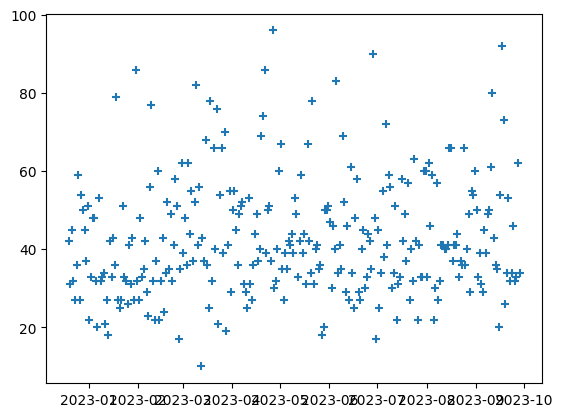

In [132]:
plt.scatter(label_filtered.groupby(['Start_Date'])['ret'].count().index, label_filtered.groupby(['Start_Date'])['ret'].count(),marker='+')

### Compare of log accumulate return

C:\Users\shoge\AppData\Local\Temp\ipykernel_24608\1188020696.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
C:\Users\shoge\AppData\Local\Temp\ipykernel_24608\1188020696.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))


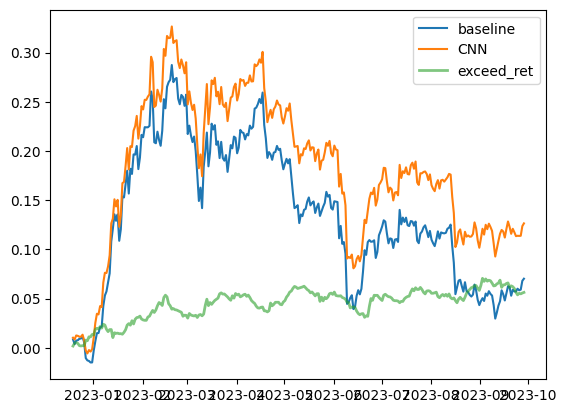

In [133]:
log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))
fig = plt.figure()
plt.plot(log_ret_baseline, label='baseline')
plt.plot(log_ret_cnn, label='CNN')
plt.plot(log_ret_cnn - log_ret_baseline, alpha=0.6, lw=2, label='exceed_ret')
plt.legend()
plt.show()
fig.savefig('../pic/performance1.png',dpi=300)


In [228]:
# Group by Predict_Date and Asset, and calculate the 50th percentile of market cap for each group
daily_market_cap_percentiles = label_df.groupby(['Predict_Date', 'Asset'])['Market_Cap'].quantile(0.5).reset_index()
# Pivot the percentiles data to have dates as index and assets as columns
pivoted_market_cap_percentiles = daily_market_cap_percentiles.pivot(index='Predict_Date', columns='Asset', values='Market_Cap')
# Calculate the daily 50th percentile of market cap across all assets
daily_50th_percentile = pivoted_market_cap_percentiles.quantile(0.5, axis=1)
# Compare each asset's market cap against the daily 50th percentile to determine if it's above or below
is_liquid = pivoted_market_cap_percentiles.ge(daily_50th_percentile, axis=0)
is_liquid

Asset,1INCH,AAVE,ACA,ACH,ADA,ADX,AGLD,AIR,AKT,ALCX,...,WOO,XCN,XDG,XLM,XRP,XTZ,YFI,YGG,ZEC,ZRX
Predict_Date,,,,,,,,,,,,,,,,,,,,,
2022-12-20 01:00:00,False,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2022-12-21 01:00:00,True,True,True,False,True,False,False,False,False,False,...,True,True,False,True,False,True,True,False,True,True
2022-12-22 01:00:00,True,True,True,False,True,False,False,False,False,False,...,True,True,False,True,False,True,True,False,True,True
2022-12-23 01:00:00,True,True,True,False,True,False,False,False,False,False,...,True,True,False,True,False,True,True,False,True,True
2022-12-24 01:00:00,True,True,True,False,True,False,False,False,False,False,...,True,True,False,True,False,True,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25 01:00:00,True,True,False,True,True,False,False,False,True,False,...,True,False,False,True,False,True,True,False,True,False
2023-09-26 01:00:00,True,True,False,True,True,False,False,False,True,False,...,True,False,False,True,False,True,True,False,True,False
2023-09-27 01:00:00,True,True,False,True,True,False,False,False,True,False,...,True,False,False,True,False,True,True,False,True,False


In [353]:
# Pivot the DataFrame
pivoted_logit_df = label_df.pivot(index='End_Date', columns='Asset', values='predict_logit')
pivoted_return_df = label_df.pivot(index='End_Date', columns='Asset', values='Ret_24H')
# Filter assets based on the daily market cap percentile
filtered_logit_df = pivoted_logit_df[is_liquid]

# Define a threshold for strong predict logits (e.g., top 10% within the filtered assets)
logit_threshold = filtered_logit_df.quantile(0.5, axis=1)

# For each day, select assets with logits above the threshold
selected_assets = (filtered_logit_df.gt(logit_threshold, axis=0)).astype(int)

# Calculate returns based on the selected assets
daily_returns = (selected_assets * pivoted_return_df[is_liquid]).mean(axis=1)
logit_threshold



End_Date
2022-12-21 01:00:00    0.431836
2022-12-22 01:00:00    0.411462
2022-12-23 01:00:00    0.437306
2022-12-24 01:00:00    0.375408
2022-12-25 01:00:00    0.388712
                         ...   
2023-09-26 01:00:00    0.424278
2023-09-27 01:00:00    0.440636
2023-09-28 01:00:00    0.404298
2023-09-29 01:00:00    0.426483
2023-09-30 01:00:00         NaN
Name: 0.5, Length: 284, dtype: float32

In [354]:
# # Determine assets for going long (top 10% of predict logits)
# long_threshold = filtered_logit_df.quantile(0.9, axis=1)
# long_positions = filtered_logit_df.gt(long_threshold, axis=0).astype(int)

# # Determine assets for going short (bottom 10% of predict logits)
# short_threshold = filtered_logit_df.quantile(0.1, axis=1)
# short_positions = filtered_logit_df.lt(short_threshold, axis=0).astype(int) * -1

# # Combine long and short positions
# selected_assets = long_positions + short_positions

# # Calculate returns based on the selected assets
# daily_returns = (selected_assets * pivoted_return_df[is_liquid]).mean(axis=1)


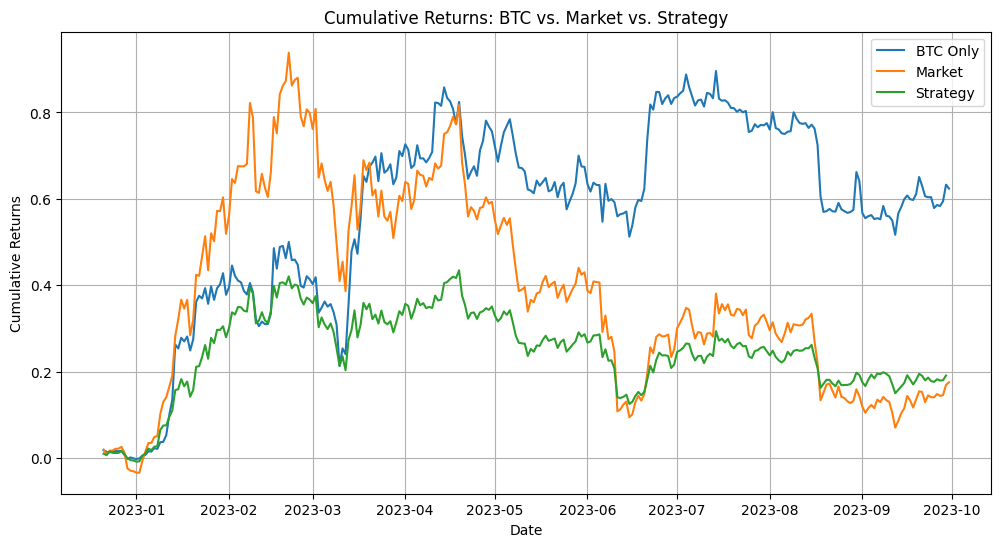

In [355]:
benchmark_asset = 'BTC'
# Extract BTC returns
benchmark_returns = pivoted_return_df[benchmark_asset]

# Calculate cumulative returns for BTC
bnchmrk_cumulative_returns = (1 + benchmark_returns).cumprod() - 1

# Ensure 'daily_returns' is a Series with dates as index from previous steps
strategy_cumulative_returns = (1 + daily_returns).cumprod() - 1

# Market returns
market_cumulative_returns = (1 + pivoted_return_df.mean(axis=1)).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(bnchmrk_cumulative_returns, label=f'{benchmark_asset} Only')
plt.plot(market_cumulative_returns, label='Market')
plt.plot(strategy_cumulative_returns, label='Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns: BTC vs. Market vs. Strategy')
plt.legend()
plt.grid(True)
plt.show()

In [305]:
# Assuming 'daily_returns' is a Series with dates as index from previous steps
annualized_return = pd.Series({
    benchmark_asset: benchmark_returns.mean() * 252,
    'Strategy': daily_returns.mean() * 252
})

volatility = pd.Series({
    benchmark_asset: benchmark_returns.std() * (252 ** 0.5),
    'Strategy': daily_returns.std() * (252 ** 0.5)
})

risk_free_rate = 0
sharpe_ratio = (annualized_return - risk_free_rate) / volatility

downside_deviation = pd.Series({
    benchmark_asset: benchmark_returns[benchmark_returns < 0].std() * (252 ** 0.5),
    'Strategy': daily_returns[daily_returns < 0].std() * (252 ** 0.5)
})
sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation

bm_rolling_max = bnchmrk_cumulative_returns.cummax()
bm_daily_drawdown = bnchmrk_cumulative_returns / bm_rolling_max - 1.0
bm_max_drawdown = bm_daily_drawdown.cummin().min()

strategy_rolling_max = strategy_cumulative_returns.cummax()
strategy_daily_drawdown = strategy_cumulative_returns / strategy_rolling_max - 1.0
strategy_max_drawdown = strategy_daily_drawdown.cummin().min()

max_drawdown = pd.Series({
    benchmark_asset: bm_max_drawdown,
    'Strategy': strategy_max_drawdown
})

position_changes = selected_assets.diff().fillna(0)
turnover = position_changes.abs().sum() / len(selected_assets)
turnover = pd.Series({
    benchmark_asset: 0,
    'Strategy': turnover.mean() * 252
})
performance_metrics = pd.DataFrame({
    'Annualized_Return': annualized_return,
    'Volatility': volatility,
    'Sharpe_Ratio': sharpe_ratio,
    'Sortino_Ratio': sortino_ratio,
    'Max_Drawdown': max_drawdown,
    'Turnover': turnover
})



performance_metrics

,Annualized_Return,Volatility,Sharpe_Ratio,Sortino_Ratio,Max_Drawdown,Turnover
BTC,0.499270,0.374946,1.331579,2.295118,-1.126102,0.000000
Strategy,0.068401,0.163785,0.417624,0.566339,-0.857150,101.383483
